In [1]:
%env LLM_BASE_URL=https://api.siliconflow.cn/v1
%env LLM_API_KEY=sk-替换为自己的秘钥

env: LLM_BASE_URL=https://api.siliconflow.cn/v1
env: LLM_API_KEY=sk-替换为自己的秘钥


In [3]:
%%capture --no-stderr
!pip install -U langchain langchain_community pypdf sentence_transformers chromadb

In [4]:
import os
import pandas as pd

In [5]:
expr_version = '01_baseline_scoring_qwen3_32b_250607'

preprocess_output_dir = os.path.join('outputs', 'v1_20240713')
expr_dir = os.path.join('experiments', expr_version)

os.makedirs(expr_dir, exist_ok=True)

# 读取文档

In [6]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(os.path.join('data', '2024全球经济金融展望报告.pdf'))
documents = loader.load()

qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))

# 文档切分

In [7]:
from uuid import uuid4
import os
import pickle

from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_docs(documents, filepath, chunk_size=400, chunk_overlap=40, seperators=['\n\n\n', '\n\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        print('found cache, restoring...')
        return pickle.load(open(filepath, 'rb'))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=seperators
    )
    split_docs = splitter.split_documents(documents)
    for chunk in split_docs:
        chunk.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))

    return split_docs

In [8]:
splitted_docs = split_docs(documents, os.path.join(preprocess_output_dir, 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)

found cache, restoring...


# 检索

In [9]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import Chroma
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        # show_progress=True
        query_instruction='为这个句子生成表示以用于检索相关文章：'
    )
    return embeddings

device: cuda


In [10]:
import jieba
import shutil

from tqdm.auto import tqdm
from langchain_community.vectorstores import Chroma

model_path = 'BAAI/bge-large-zh-v1.5'
embeddings = get_embeddings(model_path)

persist_directory = os.path.join(expr_dir, 'chroma', 'bge')
shutil.rmtree(persist_directory, ignore_errors=True)
vector_db = Chroma.from_documents(
    splitted_docs,
    embedding=embeddings,
    persist_directory=persist_directory
)

[2025-06-17 15:16:24,184] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld: cannot find -laio
collect2: error: ld returned 1 exit status
/usr/bin/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `dlvsym'
/usr/bin/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `dlopen'
/usr/bin/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `dlclose'
/usr/bin/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `dlerror'
/usr/bin/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `dlsym'
collect2: error: ld returned 1 exit status


## 计算检索准确率

In [11]:
test_df = qa_df[(qa_df['dataset'] == 'test') & (qa_df['qa_type'] == 'detailed')]

In [12]:
def get_hit_stat_df(top_k_arr=list(range(1, 9))):
    hit_stat_data = []

    for k in tqdm(top_k_arr):
        for idx, row in test_df.iterrows():
            question = row['question']
            true_uuid = row['uuid']
            # chunks = retrieve_fn(question, k=k)
            chunks = vector_db.similarity_search(question, k=k)
            retrieved_uuids = [doc.metadata['uuid'] for doc in chunks]

            hit_stat_data.append({
                'question': question,
                'top_k': k,
                'hit': int(true_uuid in retrieved_uuids),
                'retrieved_chunks': len(chunks)
            })
    hit_stat_df = pd.DataFrame(hit_stat_data)
    return hit_stat_df

In [13]:
hit_stat_df = get_hit_stat_df()

  0%|          | 0/8 [00:00<?, ?it/s]

In [14]:
hit_stat_df.groupby(['top_k'])['hit'].mean().reset_index().rename(columns={'hit': 'hit_rate'})

,top_k,hit_rate
0,1,0.462366
1,2,0.591398
2,3,0.688172
3,4,0.774194
4,5,0.806452
5,6,0.817204
6,7,0.838710
7,8,0.849462


<Axes: xlabel='top_k', ylabel='hit'>

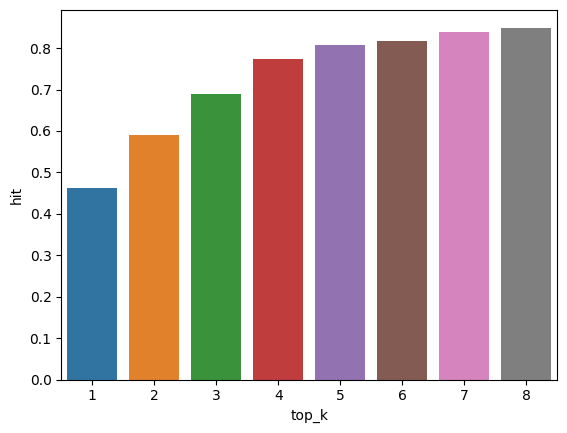

In [15]:
import seaborn as sns

sns.barplot(x='top_k', y='hit', data=hit_stat_df, errorbar=None)

# 生成答案

In [16]:
import time

def rag(llm, query, n_chunks=4):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{query}}
请回答：
""".strip()
    chunks = vector_db.similarity_search(query, k=n_chunks)
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{query}}', query)
    retry_count = 3

    resp = ''
    while retry_count > 0:
        try:
            resp = llm.invoke(prompt + '/no_think')
            resp = resp.split('</think>')[-1].strip()
            break
        except Exception as e:
            retry_count -= 1
            sleeping_seconds = 2 ** (4 - retry_count)
            print(f"query={query}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
            
            time.sleep(sleeping_seconds)
    
    return resp, chunks

## 预测

In [17]:
from langchain.llms import Ollama

ollama_llm = Ollama(
    model='qwen2:7b-instruct',
    base_url='http://localhost:11434',
    top_k=1
)

/tmp/ipykernel_2565194/3342461511.py:3: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  ollama_llm = Ollama(


In [18]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

def predict(llm, prediction_df, n_chunks):
    prediction_df = prediction_df.copy()
    answer_dict = {}

    for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        uuid = row['uuid']
        question = row['question']
        answer, chunks = rag(llm, question, n_chunks=n_chunks)
        assert len(chunks) <= n_chunks
        answer_dict[question] = {
            'uuid': uuid,
            'ref_answer': row['ref_answer'],
            'gen_answer': answer,
            'chunks': chunks
        }
        
    prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
    prediction_df.loc[:, 'chunks'] = prediction_df['question'].apply(lambda q: answer_dict[q]['chunks'])

    return prediction_df

In [19]:
pred_df = predict(ollama_llm, prediction_df, n_chunks=3)

  0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
pred_df.head(2)

,uuid,question,qa_type,ref_answer,gen_answer,chunks
0,e73a0c9d-d42b-4350-a4c3-b38bf67c68a5,报告的发布机构是什么？,detailed,中国银行研究院,中国银行研究院,[page_content='研究院\n中国北京市复兴门内大街1号\n邮编：100818\n...
1,e73a0c9d-d42b-4350-a4c3-b38bf67c68a5,报告的发布日期是什么时候？,detailed,2023年12月12日,2023年12月12日,[page_content='全球经济金融展望报告\n中国银行研究院 32 2024年\n图...


# 评估

In [21]:
from langchain_openai import ChatOpenAI
import time

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='Qwen/Qwen3-32B',
    temperature=0
)

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in prediction_df.iterrows():
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip() + '/no_think'
        
        retry_count = 3
        result = ''
        
        while retry_count > 0:
            try:
                result = judge_llm.invoke(prompt).content
                result = result.split('</think>')[-1].strip()
                break
            except Exception as e:
                retry_count -= 1
                sleeping_seconds = 2 ** (4 - retry_count)
                print(f"query={query}, error={e}, sleeping={sleeping_seconds}, remaining retry count={retry_count}")
                
                time.sleep(sleeping_seconds)
        
        results.append(result)

        time.sleep(1)
    return results

In [22]:
pred_df['raw_score'] = evaluate(pred_df)
pred_df['score'] = (pred_df['raw_score'] == '是').astype(int)

In [23]:
print(f"raw_score unique: {pred_df['raw_score'].unique()}, accuracy={pred_df['score'].mean()}")

raw_score unique: ['是' '否'], accuracy=0.79
